[AutoRec: Autoencoders Meet Collaborative Filtering](https://users.cecs.anu.edu.au/~akmenon/papers/autorec/autorec-paper.pdf)

In [ ]:
!sudo pip install -U future -q

In [ ]:
from __future__ import print_function, division
from builtins import range, input

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import save_npz, load_npz

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
from keras.optimizers import SGD

from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz

In [ ]:
# load in the data
df = pd.read_csv("/content/drive/MyDrive/recomendacao/ratings_small.csv")

In [ ]:
N = df.userId.max() + 1 # number of users
M = df.movieId.max() + 1 # number of movies

# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

A = lil_matrix((N, M))
print("Calling: update_train")
count = 0
def update_train(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/cutoff))

  i = int(row.userId)
  j = int(row.movieId)
  A[i,j] = row.rating
df_train.apply(update_train, axis=1)

# mask, to tell us which entries exist and which do not
A = A.tocsr()
mask = (A > 0)
save_npz("Atrain.npz", A)

# test ratings dictionary
A_test = lil_matrix((N, M))
print("Calling: update_test")
count = 0
def update_test(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/len(df_test)))

  i = int(row.userId)
  j = int(row.movieId)
  A_test[i,j] = row.rating
df_test.apply(update_test, axis=1)
A_test = A_test.tocsr()
mask_test = (A_test > 0)
save_npz("Atest.npz", A_test)

Calling: update_train
Calling: update_test


In [ ]:
# config
batch_size = 128
epochs = 5
reg = 0.0001
# reg = 0

A = load_npz("Atrain.npz")
A_test = load_npz("Atest.npz")
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0

In [ ]:
# make copies since we will shuffle
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

N: 611 M: 193610
N // batch_size: 4


In [ ]:
# center the data
mu = A.sum() / mask.sum()
print("mu:", mu)

mu: 3.50324168195567


In [ ]:
# build the model - just a 1 hidden layer autoencoder
i = Input(shape=(M,))
# bigger hidden layer size seems to help!
x = Dropout(0.7)(i)
x = Dense(700, activation='tanh', kernel_regularizer=l2(reg))(x)
# x = Dropout(0.5)(x)
x = Dense(M, kernel_regularizer=l2(reg))(x)

In [ ]:
#Criamos nosso autoencoder, no qual apenas vai tentar recriar sua entrada
def custom_loss(y_true, y_pred):
  mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
  diff = y_pred - y_true
  sqdiff = diff * diff * mask
  sse = K.sum(K.sum(sqdiff))
  n = K.sum(K.sum(mask))
  return sse / n

In [ ]:
def generator(A, M):
  while True:
    A, M = shuffle(A, M)
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      a = a - mu * m 
      noisy = a 
      yield noisy, a

In [ ]:
def test_generator(A, M, A_test, M_test):
  # assumes A and A_test are in corresponding order
  # both of size N x M
  while True:
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      at = A_test[i*batch_size:upper].toarray()
      mt = M_test[i*batch_size:upper].toarray()
      a = a - mu * m
      at = at - mu * mt
      yield a, at

In [ ]:
model = Model(i, x)
model.compile(
  loss=custom_loss,
  optimizer=SGD(lr=0.08, momentum=0.9),
  # optimizer='adam',
  metrics=[custom_loss],
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
r = model.fit(
  generator(A, mask),
  validation_data=test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
  epochs=epochs,
  steps_per_epoch=A.shape[0] // batch_size + 1,
  validation_steps=A_test.shape[0] // batch_size + 1,
)

Epoch 1/5
5/5 [==============================] - 43s 8s/step - loss: 1.3714 - custom_loss: 1.0976 - val_loss: 1.3559 - val_custom_loss: 1.0803
Epoch 2/5
5/5 [==============================] - 42s 9s/step - loss: 1.3642 - custom_loss: 1.0851 - val_loss: 1.3542 - val_custom_loss: 1.0788
Epoch 3/5
5/5 [==============================] - 37s 8s/step - loss: 1.3625 - custom_loss: 1.0800 - val_loss: 1.3518 - val_custom_loss: 1.0768
Epoch 4/5
5/5 [==============================] - 36s 8s/step - loss: 1.3578 - custom_loss: 1.0783 - val_loss: 1.3491 - val_custom_loss: 1.0744
Epoch 5/5
5/5 [==============================] - 36s 8s/step - loss: 1.3442 - custom_loss: 1.0647 - val_loss: 1.3457 - val_custom_loss: 1.0715


In [ ]:
print(r.history.keys())

dict_keys(['loss', 'custom_loss', 'val_loss', 'val_custom_loss'])


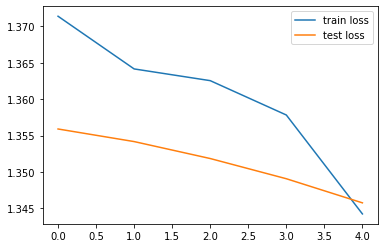

In [ ]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

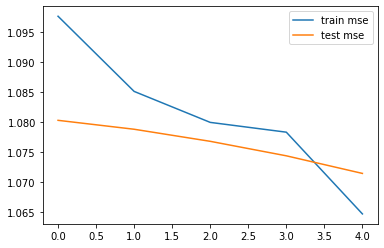

In [ ]:
# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()